In [1]:
import pandas as pd
import numpy as np

In [2]:
import pymongo
from pymongo import MongoClient
from pprint import pprint
client = MongoClient(host='localhost',port=27017)

In [3]:
from datetime import datetime
from datetime import timedelta

In [4]:
start_time = datetime.strptime('00:00 Jan 01, 2025', '%H:%M %b %d, %Y')
def seconds_to_date_time(seconds):
    return start_time + timedelta(seconds=seconds)

In [5]:
def date_to_day_str(the_date):
    return f'{the_date.year}-{the_date.month}-{the_date.day}'

In [6]:
db = client['vast2020mc1']

In [7]:
db.list_collection_names()

['Q2Seed2',
 'DemographicCategories',
 'CGCSGraphData',
 'NodeTypeDescriptions',
 'Q2Seed1',
 'Q1Graph5',
 'Q1Graph1',
 'Q2Seed3',
 'Q1Graph3',
 'Q1Graph2',
 'CGCSGraphDataNodeTypes',
 'Q1Graph4']

In [8]:
import matplotlib.pyplot as plt
from scipy.stats import describe
from matplotlib.lines import Line2D
import networkx as nx

In [9]:
eTypes = {0: 'Email', 1: 'Phone', 2:'Sell', 3:'Buy', 4: 'Author-of', 5:'Financial (income, expenditure)', 6:'Travels-to'}
cmap = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

In [10]:
# create graph
def create_graph(collection):
    cursor = collection.find({})
    df =  pd.DataFrame(list(cursor))
    G = nx.MultiDiGraph()
    for i in range(len(df)):
        G.add_edge(df.loc[i]['Source'], df.loc[i]['Target'], color=cmap[df.loc[i]['eType']])
    return G

In [11]:
# create graph
def create_graph_without_financial(collection):
    cursor = collection.find({})
    df =  pd.DataFrame(list(cursor))
    G = nx.MultiDiGraph()
    for i in range(len(df)):
        if(df.loc[i]['eType']!=5):
            G.add_edge(df.loc[i]['Source'], df.loc[i]['Target'], color=cmap[df.loc[i]['eType']])
    return G

In [12]:
from matplotlib.lines import Line2D
def plot_graph(collection):
    G = create_graph(collection)
    pos = nx.spring_layout(G, seed=1, k = 20, iterations=1000)
    # pos = nx.circular_layout(G)
    edges = G.edges(data=True)
    colors = [d['color'] for u,v,d in edges]
    plt.figure(figsize=(20, 10))
    edges = nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=10, edge_color=colors, alpha=0.3)
    nodes = nx.draw_networkx_nodes(G, pos, node_color='blue')
    
    ax = plt.gca()
    custom_lines = [Line2D([0], [0], color=c, lw=4) for c in cmap]
    ax.legend(custom_lines, list(eTypes.values()))

In [13]:
def plot_graph_without_financial(collection):
    G = create_graph_without_financial(collection)
    pos = nx.spring_layout(G, seed=1, k = 20, iterations=1000)
    # pos = nx.circular_layout(G)
    edges = G.edges(data=True)
    colors = [d['color'] for u,v,d in edges]
    plt.figure(figsize=(20, 10))
    edges = nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=10, edge_color=colors, alpha=0.3)
    nodes = nx.draw_networkx_nodes(G, pos, node_color='blue')
    
    ax = plt.gca()
    custom_lines = [Line2D([0], [0], color=c, lw=4) for c in cmap]
    ax.legend(custom_lines, list(eTypes.values()))

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


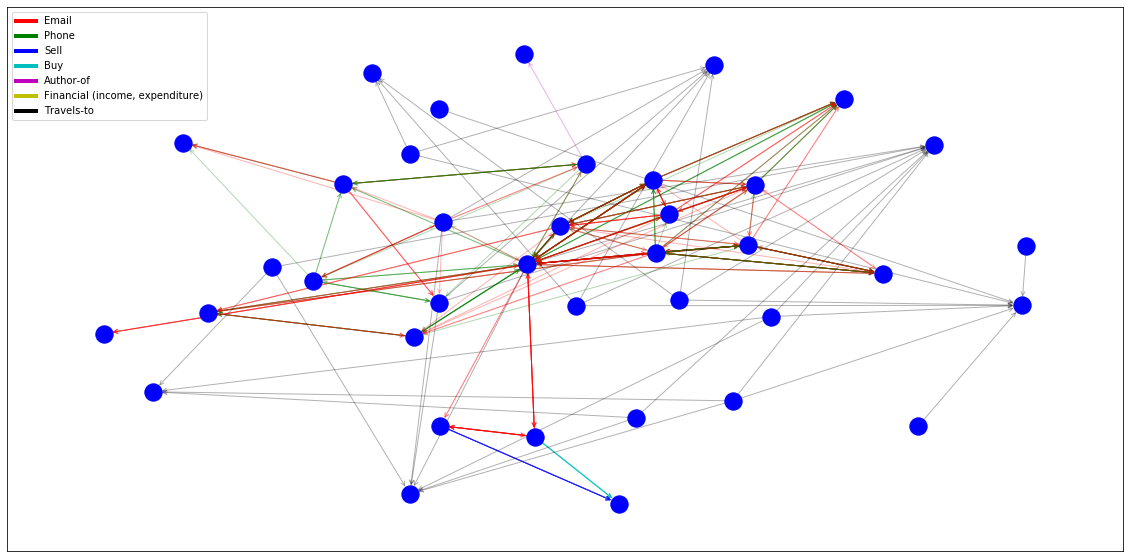

In [14]:
plot_graph_without_financial(db.Q1Graph1)

In [17]:
!pip install node2vec

  Created wheel for smart-open: filename=smart_open-2.1.0-cp37-none-any.whl size=110325 sha256=8943a1032dcdad01cca9d8136e8e0ea7cbc7de75a8efb8757797e93ebf041ff9
  Stored in directory: C:\Users\vunpham\AppData\Local\pip\Cache\wheels\25\6c\db\7dcb26f19fb260c5629af85ed1c8ef9641143444fc7ec1fa08
Successfully built smart-open
  Found existing installation: Cython 0.29.13
    Uninstalling Cython-0.29.13:


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\programdata\\anaconda3\\lib\\site-packages\\__pycache__\\cython.cpython-37.pyc'
Consider using the `--user` option or check the permissions.



In [18]:
from node2vec import Node2Vec

ModuleNotFoundError: No module named 'node2vec'

In [123]:
def get_embeddings(collection):
    n2v = Node2Vec(create_graph_without_financial(collection), dimensions=20, walk_length=16, num_walks=100, workers=2)
    model = n2v.fit(window=10, min_count=1)
    graph_vocab = list(model.wv.vocab.keys())
    embeddings = np.array([model.wv[x] for x in graph_vocab])
    return graph_vocab, embeddings

In [124]:
template_vocab, template_embeddings = get_embeddings(db.CGCSTemplate)
graph1_vocab, graph1_embeddings = get_embeddings(db.Q1Graph1)
graph2_vocab, graph2_embeddings = get_embeddings(db.Q1Graph2)
graph3_vocab, graph3_embeddings = get_embeddings(db.Q1Graph3)
graph4_vocab, graph4_embeddings = get_embeddings(db.Q1Graph4)
graph5_vocab, graph5_embeddings = get_embeddings(db.Q1Graph5)

Computing transition probabilities: 100%|██████████| 57/57 [00:00<00:00, 25607.90it/s]


In [125]:
print(len(template_embeddings))
print(len(gaph1_embeddings))
print(len(gaph2_embeddings))
print(len(gaph3_embeddings))
print(len(gaph4_embeddings))
print(len(gaph5_embeddings))

38
38
33
35
58
57


In [126]:
graph1_vocab

['538892',
 '625756',
 '572391',
 '589639',
 '490041',
 '550361',
 '599956',
 '493044',
 '492777',
 '623295',
 '635665',
 '568093',
 '561157',
 '533140',
 '591682',
 '570411',
 '640464',
 '632150',
 '464459',
 '550287',
 '512397',
 '534034',
 '499467',
 '559657',
 '649553',
 '657173',
 '509607',
 '657187',
 '542965',
 '643925',
 '599441',
 '616453',
 '585212',
 '596193',
 '629627',
 '616050',
 '590502',
 '570284']

In [76]:
t = template_embeddings.sum(axis=0)
g1 = gaph1_embeddings.sum(axis=0)
g2 = gaph2_embeddings.sum(axis=0)
g3 = gaph3_embeddings.sum(axis=0)
g4 = gaph4_embeddings.sum(axis=0)
g5 = gaph5_embeddings.sum(axis=0)

In [88]:
# normalize
t = t / np.linalg.norm(t)
g1 = g1 / np.linalg.norm(g1)
g2 = g2 / np.linalg.norm(g2)
g3 = g3 / np.linalg.norm(g3)
g4 = g4 / np.linalg.norm(g4)
g5 = g5 / np.linalg.norm(g5)

In [89]:
np.dot(t, g1)

0.31874132

In [90]:
np.dot(t, g2)

-0.22338967

In [91]:
np.dot(t, g3)

-0.28456402

In [92]:
np.dot(t, g4)

-0.11098601

In [93]:
np.dot(t, g5)

-0.082552545

In [94]:
from scipy.spatial import distance

In [95]:
distance.cosine(t, g1)

0.6812586784362793

In [96]:
distance.cosine(t, g2)

1.2233896702528

In [97]:
distance.cosine(t, g3)

1.2845640182495117

In [98]:
distance.cosine(t, g4)

1.1109860017895699

In [99]:
distance.cosine(t, g5)

1.0825525373220444

# Do the matching

AttributeError: 'dict' object has no attribute 'x'